In [1]:
%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np
from PIL import Image
from math import floor
import matplotlib.pyplot as plt
import datetime
from UAVSequence import UAVSequence, ImageSequence
from ValidationCallback import ValidationCallback
from VAEModel import Sampling, VAE
# Clear logs from previous runs
# %rm -rf ../logs/

/home/fri/UAV/ego-planner/src/neural_net/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fri/UAV/ego-planner/src/neural_net/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fri/UAV/ego-planner/src/neural_net/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fri/UAV

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10417984897419101464
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16601123828022033433
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
NUM_INPUTS = 13
NUM_OUTPUTS = 9

img_shape = (480, 640)

# Load the dataset input and output
x = np.loadtxt('../dataset/0_input.csv', delimiter=',')#, usecols=tuple(range(NUM_INPUTS))) # (num training points, 13)
y = np.loadtxt('../dataset/0_output.csv', delimiter=',', usecols=tuple(range(NUM_OUTPUTS))) # (num training points, 11)

# Shuffle x and y, but store the indices so we can still match them with the images
hash_table = np.random.permutation(len(x))

x = x[hash_table]
y = y[hash_table]

# X = np.zeros((len(inputNums), *img_shape, 1)) # (num training points, 480, 640)

# For each of the training examples there should be exactly 1 image
# for i in range(0, len(inputNums)):
#     image = Image.open('../dataset/img_' + str(i) + '.jpg') 
#     imageArr = np.asarray(image).reshape(*img_shape, 1) # Converts the image into a 2D 480*640 array

#     X[i] = imageArr / 255


# img_data = ImageDataGenerator(rescale=1/255)
# img_data.flow_from_directory('../dataset', target_size=img_shape, color_mode='grayscale')


In [4]:
max_mag = 2.0

# print(inputNums.shape);

# def mag(x, y):
#     return np.sqrt(x * x + y * y)

# for inputRow in inputNums:
#     m = mag(*inputRow[0:2]) # constrain goal positions
#     if m > max_mag:
#         inputRow[0] = inputRow[0] * max_mag / m 
#         inputRow[1] = inputRow[1] * max_mag / m 

Let's view some of our data images

In [5]:
num_show = 10

# fig = plt.figure(figsize=(480/20, 640/20), dpi=100)
# for i in range(num_show):
#     ax = fig.add_subplot(num_show, 1, i+1)
#     plt.imshow(X[i])

Next comes actually training on the data. 
PS. If you want to view the tensorboard data, run `tensorboard --logdir logs/fit` in another window.

In [6]:
# numerical_inputs = Input(shape=(NUM_INPUTS,))
# image_inputs = Input(shape=(*img_shape, 1))

latent_dim = 1000

encoder_inputs = Input(shape=(*img_shape, 1), name="encoder_input")
a = Conv2D(32, 7, strides=4, padding="same", activation="relu")(encoder_inputs)
a = Conv2D(32, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2D(64, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2D(64, 5, strides=5, padding="same", activation="relu")(a)
a = Flatten()(a)
z_mean = Dense(latent_dim, name="z_mean")(a)
z_log_var = Dense(latent_dim, name="z_log_var")(a)
z = Sampling()([z_mean, z_log_var])
# encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder = Model(encoder_inputs, z_mean, name="encoder")

# latent_inputs = Input(shape=(latent_dim,))
a = Dense(6 * 8 * 64, activation="relu")(z)
a = Reshape((6, 8, 64))(a)
a = Conv2DTranspose(64, 5, strides=5, padding="same", activation="relu")(a)
a = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(a)
decoder_outputs = Conv2DTranspose(1, 7, strides=4, padding="same", activation="relu")(a)
# decoder_outputs = UpSampling2D(size=(4,4))(a)
# decoder = Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

# Process the image data first
# x_image = Conv2D(32, (7, 7), strides=(4, 4), padding='same', activation='relu')(image_inputs)
# x_image = Conv2D(64, (5, 5), strides=(4, 4), padding="same", activation="relu")(x_image)
# x_image = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x_image)
# x_image = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x_image)
# x_image = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x_image)
# x_image = Model(image_inputs, x_image)
# x_image = Flatten()(x_image.output)

# print(x_image.shape)
# print(numerical_inputs.shape)

# Combine the latent space representation with the numerical input
# combined = concatenate([x_image, numerical_inputs])
# print(combined.shape)
# x_combined = Dense(300, kernel_regularizer=l2(0.01), activation='relu')(combined)
# x_combined = Dense(60, kernel_regularizer=l2(0.01), activation='relu')(x_combined)
# outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.01), activation='linear')(x_combined)
def vae_loss(input_img, reconstructed_img):
#     reconstruction_loss = tf.reduce_mean(
#         tf.keras.losses.binary_crossentropy(input_img, reconstructed_img)
#     )
    reconstruction_loss = tf.keras.losses.MSE(input_img, reconstructed_img)
    reconstruction_loss *= 480 * 640
    
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    total_loss = reconstruction_loss + kl_loss
    return total_loss

vae = Model(encoder_inputs, decoder_outputs)
vae.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 160, 32) 1600        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 80, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 40, 64)   18496       conv2d_1[0

In [7]:
# model = Model([image_inputs, numerical_inputs], outputs)

# model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = model.fit([X, inputNums], y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])
# history = model.fit(xy, epochs=100, callbacks=[ValidationCallback(xy_validation), tensorboard_callback] )

# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
xy = ImageSequence(x, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, False)
xy_validation = ImageSequence(x, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, True)

NUM_EPOCHS = 30
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(xy, epochs=NUM_EPOCHS, callbacks=[ValidationCallback(xy_validation)])

batch is 32
batch is 32
Epoch 1/10
239/239 [==============================] - 148s 621ms/step - loss: 6844.6939
Epoch 2/10
239/239 [==============================] - 146s 609ms/step - loss: 3928.0043
Epoch 3/10
239/239 [==============================] - 144s 602ms/step - loss: 3061.6280
Epoch 4/10
239/239 [==============================] - 139s 582ms/step - loss: 2721.8364
Epoch 5/10
239/239 [==============================] - 140s 585ms/step - loss: 2490.1833
Epoch 6/10
239/239 [==============================] - 140s 584ms/step - loss: 2297.8516
Epoch 7/10
239/239 [==============================] - 140s 588ms/step - loss: 2201.5307
Epoch 8/10
239/239 [==============================] - 141s 589ms/step - loss: 2063.4999
Epoch 9/10
239/239 [==============================] - 141s 589ms/step - loss: 1970.5766
Epoch 10/10
239/239 [==============================] - 141s 588ms/step - loss: 1901.2393


In [8]:
# Save the model
vae.save('../models/vae.tf')
# vae_dir = '../models/vae_model'
# tf.saved_model.save(vae, vae_dir)

encoder.save('../models/encoder.tf')
# encoder_dir = '../models/encoder_model'
# tf.saved_model.save(encoder, encoder_dir)

# Open Tensorboard (actually, run this on the command line on your Terminal)
# %tensorboard --logdir ../logs/fit

In [9]:
# Load the model
loaded_model_vae = tf.keras.models.load_model('../models/vae.tf', custom_objects={"Sampling": Sampling, "vae_loss": vae_loss})
loaded_model_encoder = tf.keras.models.load_model('../models/encoder.tf', custom_objects={"Sampling": Sampling, "vae_loss": vae_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


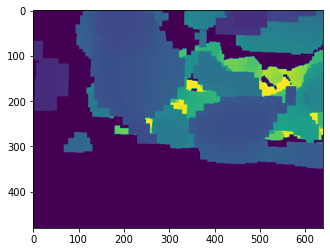

In [10]:
plt.imshow(xy[5][0][0])

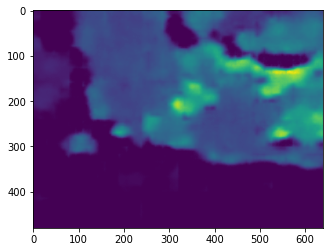

In [11]:
prediction = loaded_model_vae.predict(xy.__getitem__(5)[0])[0]
plt.imshow(prediction)

In [12]:
# # 1. Get the latent space representation of the image from the encoder
# NUM_INPUTS = 13
# NUM_OUTPUTS = 9

# VALIDATION_SPLIT = 0.2
# xy = UAVSequence(x, y, 32, img_shape, hash_table, VALIDATION_SPLIT, False)
# xy_validation = UAVSequence(x, y, 32, img_shape, hash_table, VALIDATION_SPLIT, True)


# # latent_vector = encoder.predict()
# # z_mean = encoder.get_layer("z_mean")
# encoder_input = loaded_model_encoder.get_layer("encoder_input")
# numerical_inputs = Input(shape=(NUM_INPUTS,))
# z_mean = loaded_model_encoder.get_layer("z_mean")
# z_mean = Input(shape=z_mean.shape)(z_mean)
# combined = concatenate([z_mean, numerical_inputs])
# print(combined.shape)

# z_mean = loaded_model_encoder(img, training=False)

# x_combined = Dense(300, kernel_regularizer=l2(0.01), activation='relu')(combined)
# x_combined = Dense(60, kernel_regularizer=l2(0.01), activation='relu')(x_combined)
# outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.01), activation='linear')(x_combined)

# model = Model([encoder_input, numerical_inputs], outputs)
# model.summary()

In [13]:
# 1. Get the latent space representation of the image from the encoder
NUM_INPUTS = 13
NUM_OUTPUTS = 9
img_shape = (480, 640)

image_inputs = Input(shape=(*img_shape, 1))
numerical_inputs = Input(shape=(NUM_INPUTS,))

z_mean = loaded_model_encoder(image_inputs, training=False)
z_mean = Flatten()(z_mean)
combined = concatenate([z_mean, numerical_inputs])
x_combined = Dense(300, kernel_regularizer=l2(0.01), activation='relu')(combined)
x_combined = Dense(60, kernel_regularizer=l2(0.01), activation='relu')(x_combined)
outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.01), activation='linear')(x_combined)

model = Model([image_inputs, numerical_inputs], outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 1000)         3204808     input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1000)         0           encoder[1][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13)]         0                                            
____________________________________________________________________________________________

In [14]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
xy = UAVSequence(x, y, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, False)
xy_validation = UAVSequence(x, y, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, True)

NUM_EPOCHS = 100
model.compile(optimizer='adam', loss=tf.keras.losses.MSE)
model.fit(xy, epochs=NUM_EPOCHS, callbacks=[ValidationCallback(xy_validation)])

batch is 32
batch is 32
Epoch 1/10
239/239 [==============================] - 51s 214ms/step - loss: 16.3785
Epoch 2/10
239/239 [==============================] - 50s 211ms/step - loss: 6.5022
Epoch 3/10
239/239 [==============================] - 50s 211ms/step - loss: 3.4285
Epoch 4/10
239/239 [==============================] - 51s 213ms/step - loss: 2.2880
Epoch 5/10
239/239 [==============================] - 50s 210ms/step - loss: 1.8477
Epoch 6/10
239/239 [==============================] - 51s 213ms/step - loss: 1.6255
Epoch 7/10
239/239 [==============================] - 50s 210ms/step - loss: 1.5173
Epoch 8/10
239/239 [==============================] - 51s 211ms/step - loss: 1.3861
Epoch 9/10
239/239 [==============================] - 50s 208ms/step - loss: 1.3258
Epoch 10/10
239/239 [==============================] - 50s 210ms/step - loss: 1.1620


In [20]:
# Save the model
model.save('../models/complete.tf')

In [21]:
loaded_model_complete = tf.keras.models.load_model('../models/complete.tf', custom_objects={"Sampling": Sampling, "vae_loss": vae_loss})

In [22]:
print(xy[5][1][1])
prediction = model.predict(xy.__getitem__(5)[0])[1]
print(prediction)

[-12.938299  -9.866716   1.089456   0.421963   1.595969  -0.222052
  -0.640543   0.181245   0.140588]
[-11.256937   -11.311914     0.9894643    0.7223017    1.3781552
  -0.04005485  -0.83354783   0.03639185   0.07598005]
